In [92]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable


# Hyper Parameters
num_epochs = 2
batch_size = 1
learning_rate = 0.001

# MNIST Dataset
train_dataset = dsets.MNIST(root='./data/',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data/',
                           train=False, 
                           transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [9]:
import time

In [93]:
# CNN Model (2 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, 1, kernel_size=3, padding=2),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )
        self.layer1 = nn.Conv2d(1,1, kernel_size=4, padding=4)
        self.layer1.weight.data = torch.Tensor([[0,-1,1,0],[-1,-3,3,0],[-1,-3,3,0],[0,-1,1,0]]).unsqueeze(0).unsqueeze(0)
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        print('convb weights',self.layer1.weight.data)
        return out
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
        
cnn = CNN()
cnn.cuda()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

In [105]:
!git config --global user.name 'missglory'
!git config --global user.email 'xhaustful@gmail.com'

convb weights 
(0 ,0 ,.,.) = 
  0 -1  1  0
 -1 -3  3  0
 -1 -3  3  0
  0 -1  1  0
[torch.cuda.FloatTensor of size 1x1x4x4 (GPU 0)]

out shape  torch.Size([1, 1, 33, 33])


RuntimeError: invalid argument 1: only batches of spatial targets supported (3D tensors) but got targets of dimension: 1 at c:\anaconda2\conda-bld\pytorch_1519501749874\work\torch\lib\thcunn\generic/SpatialClassNLLCriterion.cu:14

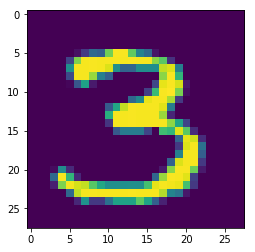

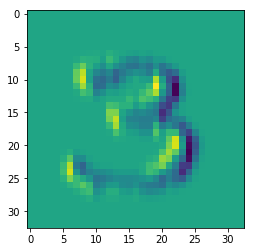

In [94]:
# Train the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
#         print('image', images.data)
        plt.imshow(images.data.squeeze().cpu().numpy())
        plt.figure()
        
#         print('outputs', outputs.shape)
        outs = outputs.data.squeeze().cpu().numpy()
        plt.imshow(outs)
        print('out shape ', outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))



In [ ]:
# Test the Model
cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images).cuda()
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()

print('Test Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))

# Save the Trained Model
torch.save(cnn.state_dict(), 'cnn.pkl')